In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchsummary import summary
import pickle
import matplotlib.pyplot as plt
import librosa

from tqdm import tqdm_notebook
import os
import sys
from pathlib import Path
from datetime import datetime

# Data gaining

In [ ]:
!unzip -q /content/gdrive/MyDrive/data_2.zip

In [ ]:
ROOT = "data_2/"
ALL_SOUNDS = list(Path(ROOT).glob("**/*.wav"))
ALL_SOUNDS = list(filter(lambda x: not x.name.startswith("."), ALL_SOUNDS))
print("Number of sounds:", len(ALL_SOUNDS))

Number of sounds: 97377


In [ ]:
data_list = []
with open('/content/gdrive/MyDrive/data_base_2.pickle', 'rb') as fh:
  data_list = pickle.load(fh)

In [ ]:
len(data_list)

97377

In [ ]:
np.random.seed(123456)
torch.manual_seed(123456)

# Data preporation

In [ ]:
class SoundDataset(torch.utils.data.Dataset):
    def __init__(self, rootdir, subset, transform=None):
        self.transform = transform
        self.rootdir = rootdir
        self.subset = subset

    def __getitem__(self, index):
        xname, y = self.subset[index].values()
        X, _ = librosa.load(f"{self.rootdir}/{xname}.wav", sr=8000)
        if self.transform:
            X = torch.unsqueeze(self.transform(X.astype('float32')), 0)
            y = torch.unsqueeze(self.transform(y.astype('float32')), 0)
        return X, y

    def __len__(self):
        return len(self.subset)

class ToTensor(object):
    def __call__(self, sample):
        return torch.from_numpy(sample)

In [ ]:
def sound_show(inp, title=None):
    inp = torch.squeeze(inp).numpy()
    print(inp)
    time = np.linspace(0., inp.size/8000, inp.size)
    plt.figure(figsize=(16, 8))
    plt.plot(time, inp)
    plt.title(title)
    plt.show()

{'train': 78300, 'valid': 8700, 'test': 10377}
[-0.04822356  0.01343265 -0.01072492 ...  0.01078868 -0.11634375
 -0.0239173 ]


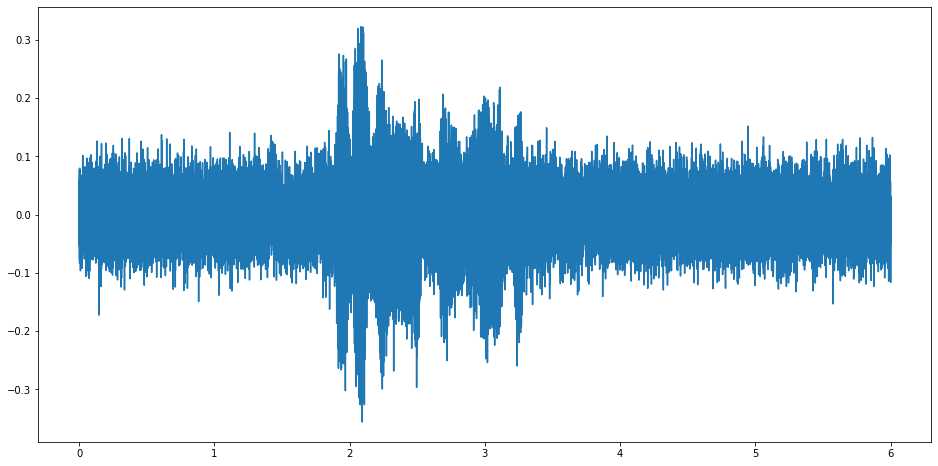

In [ ]:
path_data = '/content/data_2'

end_idx_tv = 87000
train_valid_subset = data_list[:end_idx_tv]
test_subset = data_list[end_idx_tv:]

lengths = [int(len(train_valid_subset) * 0.9), int(len(train_valid_subset) * 0.1)]
train_subset, valid_subset = torch.utils.data.random_split(train_valid_subset, lengths)

transform_baseline = transforms.Compose([ToTensor()])
data_set = {
            'train': SoundDataset(rootdir=path_data, subset=train_subset, transform=transform_baseline),
            'valid': SoundDataset(rootdir=path_data, subset=valid_subset, transform=transform_baseline),
            'test': SoundDataset(rootdir=path_data, subset=test_subset, transform=transform_baseline)
           }

batch_size = 512
loaders = {
            'train': torch.utils.data.DataLoader(data_set['train'], batch_size=batch_size, shuffle=True),
            'valid': torch.utils.data.DataLoader(data_set['valid'], batch_size=batch_size, shuffle=True),
            'test': torch.utils.data.DataLoader(data_set['test'], batch_size=batch_size, shuffle=False)
          }

dataset_sizes = {x: len(data_set[x]) for x in ['train', 'valid', 'test']}
X, y = data_set['train'][0]
print(dataset_sizes)
sound_show(X, title=None)

# Models init

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
class ConvConvT1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=101,
                      stride=20, padding=50),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=64),

            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=101,
                      stride=20, padding=50),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=128),

            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=101,
                      stride=20, padding=50),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=256),
        )

        self.convT_layers = nn.Sequential(
            nn.ConvTranspose1d(in_channels=256,
                               out_channels=128,
                               kernel_size=101,
                               stride=20,
                               padding=50,
                               output_padding=19),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=128),
            nn.ConvTranspose1d(in_channels=128,
                               out_channels=64,
                               kernel_size=101,
                               stride=20,
                               padding=50,
                               output_padding=19),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=64),
            nn.ConvTranspose1d(in_channels=64,
                               out_channels=1,
                               kernel_size=101,
                               stride=20,
                               padding=50,
                               output_padding=19),
        )

    def forward(self, x):
        return self.convT_layers(self.conv_layers(x))

class ConvConvT2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=(20, 5),
                      stride=(10, 2),
                      padding=(10, 2)),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(2, 2),
                      padding=(1, 1)),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(num_features=128),
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=(13, 3),
                      stride=(1, 2),
                      padding=(0, 1)),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(num_features=256),
        )

        self.convT_layers = nn.Sequential(
            nn.ConvTranspose1d(in_channels=256,
                               out_channels=128,
                               kernel_size=101,
                               stride=10,
                               padding=50,
                               output_padding=9),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=128),
            nn.ConvTranspose1d(in_channels=128,
                               out_channels=64,
                               kernel_size=101,
                               stride=10,
                               padding=50,
                               output_padding=9),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=64),
            nn.ConvTranspose1d(in_channels=64,
                               out_channels=1,
                               kernel_size=101,
                               stride=20,
                               padding=50,
                               output_padding=19),
        )

    def forward(self, x):
        return self.convT_layers(torch.squeeze(self.conv_layers(x), -2))

In [ ]:
def init_weights(m):
    if type(m) in (nn.Conv1d, nn.Conv2d, nn.ConvTranspose1d):
        nn.init.kaiming_uniform_(m.weight, a=0.2, nonlinearity='leaky_relu')
    else:
        print('Not setting weights for type {}'.format(type(m)))

In [ ]:
model = ConvConvT1D().cuda()
model.apply(init_weights)

Not setting weights for type <class 'torch.nn.modules.dropout.Dropout'>
Not setting weights for type <class 'torch.nn.modules.activation.LeakyReLU'>
Not setting weights for type <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
Not setting weights for type <class 'torch.nn.modules.dropout.Dropout'>
Not setting weights for type <class 'torch.nn.modules.activation.LeakyReLU'>
Not setting weights for type <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
Not setting weights for type <class 'torch.nn.modules.dropout.Dropout'>
Not setting weights for type <class 'torch.nn.modules.activation.LeakyReLU'>
Not setting weights for type <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
Not setting weights for type <class 'torch.nn.modules.container.Sequential'>
Not setting weights for type <class 'torch.nn.modules.dropout.Dropout'>
Not setting weights for type <class 'torch.nn.modules.activation.LeakyReLU'>
Not setting weights for type <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
Not setting wei

ConvConvT1D(
  (conv_layers): Sequential(
    (0): Conv1d(1, 64, kernel_size=(101,), stride=(20,), padding=(50,))
    (1): Dropout(p=0.7, inplace=False)
    (2): LeakyReLU(negative_slope=0.2)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv1d(64, 128, kernel_size=(101,), stride=(20,), padding=(50,))
    (5): Dropout(p=0.7, inplace=False)
    (6): LeakyReLU(negative_slope=0.2)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv1d(128, 256, kernel_size=(101,), stride=(20,), padding=(50,))
    (9): Dropout(p=0.7, inplace=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convT_layers): Sequential(
    (0): ConvTranspose1d(256, 128, kernel_size=(101,), stride=(20,), padding=(50,), output_padding=(19,))
    (1): Dropout(p=0.7, inplace=False)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Batch

In [ ]:
summary(model.cuda(), (1, 48000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 2400]           6,528
           Dropout-2             [-1, 64, 2400]               0
         LeakyReLU-3             [-1, 64, 2400]               0
       BatchNorm1d-4             [-1, 64, 2400]             128
            Conv1d-5             [-1, 128, 120]         827,520
           Dropout-6             [-1, 128, 120]               0
         LeakyReLU-7             [-1, 128, 120]               0
       BatchNorm1d-8             [-1, 128, 120]             256
            Conv1d-9               [-1, 256, 6]       3,309,824
          Dropout-10               [-1, 256, 6]               0
        LeakyReLU-11               [-1, 256, 6]               0
      BatchNorm1d-12               [-1, 256, 6]             512
  ConvTranspose1d-13             [-1, 128, 120]       3,309,696
          Dropout-14             [-1, 1

In [ ]:
def save(path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss_epochs': train_losses,
        'valid_loss_epochs': valid_losses,
    }, path)

In [ ]:
model_name = 'baseline'
savedir = '/content/gdrive/MyDrive'
best_path = None

max_lr = 0.05
div_factor = 250
weight_decay = 0.0005

best_acc = 0
bect_epoch = 0
epochs = 10

loss = nn.BCEWithLogitsLoss(pos_weight=torch.ones(48000, dtype=torch.float16).cuda() * 3).cuda()
optim = torch.optim.AdamW(model.parameters(), lr=max_lr / div_factor,
                             weight_decay=weight_decay, amsgrad=True)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=max_lr,
                                steps_per_epoch=len(loaders['train']),
                                epochs=epochs, div_factor=div_factor)

# Model training

In [ ]:
def train(model, optim, loss, scheduler, dataloader, epoch, device):
    total = 0
    correct = 0
    losses = []

    model.train()
    for i, batch in enumerate(tqdm_notebook(dataloader)):
        signals, marks = batch
        signals, marks = signals.cuda(), marks.cuda()
        optim.zero_grad()
        prediction = model(signals)
        loss_batch = loss(prediction, marks)
        losses.append(loss_batch.item())
        loss_batch.backward()
        optim.step()
        scheduler.step()

        total += signals.shape[0]*signals.shape[2]
        correct += (abs(torch.sigmoid(prediction) - marks) < 0.4).sum().item()

    return np.mean(losses), 100. * correct / total

In [ ]:
def test(model, loss, dataloader, epoch, device, best_acc, model_name='model'):
    total = 0
    correct = 0
    losses = []

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm_notebook(dataloader)):
            signals, marks = batch
            signals, marks = signals.cuda(), marks.cuda()
            prediction = model(signals)
            loss_batch = loss(prediction, marks)
            losses.append(loss_batch.item())

            correct += (abs(torch.sigmoid(prediction) - marks) < 0.4).sum().item()
            total += signals.shape[0]*signals.shape[2]

    return np.mean(losses), 100. * correct / total

In [ ]:
def init_model(path=None, isLoad=False):
    model = ConvConvT1D().cuda()
    loss = nn.BCEWithLogitsLoss(pos_weight=torch.ones(48000, dtype=torch.float16).cuda() * 3).cuda()
    optim = torch.optim.AdamW(model.parameters(), lr=max_lr / div_factor,
                             weight_decay=weight_decay, amsgrad=True)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=max_lr,
                                steps_per_epoch=len(loaders['train']),
                                epochs=epochs, div_factor=div_factor)
    epoch = 0
    train_losses = []
    valid_losses = []
    if isLoad:
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        train_losses = checkpoint['train_loss_epochs']
        valid_losses = checkpoint['valid_loss_epochs']
        epoch = checkpoint['epoch']
        # loss = checkpoint['loss']

    return model, loss, optim, scheduler, epoch+1, train_losses, valid_losses


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()
model, loss, optim, scheduler, epoch, train_losses, valid_losses = init_model()


for i in range(epoch, epochs):
    train_loss, train_acc = train(model, optim, loss, scheduler, loaders['train'], i, device)
    train_losses.append(train_loss)

    valid_loss, valid_acc = test(model, loss, loaders['valid'], i, device, best_acc)
    valid_losses.append(valid_loss)

    best_acc = max(best_acc, valid_acc)
    best_epoch = i if best_acc == valid_acc else best_epoch

    if i == 0 or valid_loss < np.min(valid_losses):
        best_epoch = i
        best_valid_loss = valid_loss
        if i > 0:
            prev_best_path = best_path
        best_path = os.path.join(savedir, datetime.now().strftime('{0}_{1:.3f}_%Y-%m-%d_%H-%M-%S'.format(epoch, valid_loss)))
        save(best_path)
            
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, acc: {train_acc:.5f}')
    plt.plot(np.arange(len(valid_losses)), valid_losses, label=f'Test, loss: {valid_loss:.4f}, acc: {valid_acc: .5f}')
    plt.title(f'Epoch {i}')
    plt.legend(loc='best')
    plt.show()

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/153 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# WanDB

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 100,
  "batch_size": 128
}

Error: ignored